# Survey Weights Analysis: Are They Necessary for Depression Factor Identification?

## Purpose
This notebook investigates whether using NHANES survey weights is **essential** for identifying factors most associated with depression, or if unweighted analysis produces sufficiently similar results.

---

## What Are Survey Weights and Why Do They Exist?

### The Problem: Non-Representative Sampling
NHANES doesn't randomly sample the US population. Instead, it **oversamples** certain groups:
- Hispanic persons
- Non-Hispanic Black persons
- Non-Hispanic Asian persons
- Older adults (80+)
- Low-income individuals

**Why?** To ensure enough observations for reliable subgroup analysis. If you sampled purely randomly, you might get only 50 Asian participants — too few to draw conclusions.

### The Solution: Survey Weights
Each participant receives a **weight** (`WTMEC2YR`) representing how many people in the US population they "represent." 

For example:
- An oversampled Hispanic participant might have weight = 5,000 (represents 5,000 people)
- An undersampled White participant might have weight = 50,000 (represents 50,000 people)

### Survey Design Variables in NHANES
| Variable | Meaning | Purpose |
|----------|---------|--------|
| `WTMEC2YR` | MEC Exam Weight | Adjusts for sampling probability |
| `SDMVPSU` | Primary Sampling Unit | Accounts for geographic clustering |
| `SDMVSTRA` | Strata | Accounts for stratified sampling design |

---

## Why Would Life Be MUCH Simpler Without Weights?

### 1. Statistical Complexity
- Standard ML libraries (scikit-learn, XGBoost) don't natively support survey weights
- You can't just use `model.fit(X, y)` — need specialized packages like `statsmodels` or custom implementations
- Cross-validation becomes tricky: how do you split weighted data fairly?

### 2. Computational Cost
- Weighted bootstrapping is 3-5x slower than unweighted
- Variance estimation (Taylor linearization) adds complexity

### 3. Interpretability
- "Effective sample size" differs from actual n
- Standard errors are harder to interpret
- Feature importance becomes weight-dependent

### 4. The Big Question
**If our goal is to identify WHICH factors are associated with depression (not to estimate exact population prevalence), do weights actually change our conclusions?**

Let's find out!


In [1]:
# === SETUP ===
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical packages
from scipy import stats
from scipy.stats import spearmanr, pearsonr
import statsmodels.api as sm
from statsmodels.stats.weightstats import DescrStatsW

# ML
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

# Plotting style
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")

print("✅ All imports successful")


✅ All imports successful


In [2]:
# === LOAD DATA ===
from src.loader import load_raw_data
from src.preprocessing import clean_pipeline
from src import config

# Load raw data
df_raw = load_raw_data()

# Rename columns
df = df_raw.rename(columns=config.RENAME_MAP)

# Filter adults (18+)
df = df[df["Age"] >= 18].copy()

# Apply cleaning (encoding + PHQ-9 scoring)
df = clean_pipeline(df)

print(f"\nDataset shape: {df.shape}")
print(
    f"Depression cases: {df['Depression'].sum():.0f} ({df['Depression'].mean() * 100:.1f}%)"
)


--- STARTING DATA INGESTION from C:\Users\Nikita\dev\the\data\raw ---
✅ Loaded Backbone: DEMO_J (DEMO_J.XPT)
   -> Merged DPQ_J: +9 features. New Shape: (9254, 19)
   -> Merged HSQ_J: +1 features. New Shape: (9254, 20)
   -> Merged SMQ_J: +1 features. New Shape: (9254, 21)
   -> Merged ALQ_J: +1 features. New Shape: (9254, 22)
   -> Merged PAQ_J: +1 features. New Shape: (9254, 23)
   -> Merged BMX_J: +3 features. New Shape: (9254, 26)
   -> Merged BPX_J: +2 features. New Shape: (9254, 28)
   -> Merged BIOPRO_J: +7 features. New Shape: (9254, 35)
   -> Merged CBC_J: +2 features. New Shape: (9254, 37)
   -> Merged HSCRP_J: +1 features. New Shape: (9254, 38)
   -> Merged PBCD_J: +3 features. New Shape: (9254, 41)
   -> Merged ALB_CR_J: +1 features. New Shape: (9254, 42)
   -> Merged VID_J: +1 features. New Shape: (9254, 43)
   -> Merged DXX_J: +7 features. New Shape: (9254, 50)
   -> Merged SLQ_J: +1 features. New Shape: (9254, 51)
--- DATA LOADING COMPLETE. Final Shape: (9254, 51) ---

D

SURVEY WEIGHT DISTRIBUTION (MEC_Weight)

Sample size with weights: 5,856
Min weight: 0
Max weight: 419,763
Mean weight: 42,205
Median weight: 24,993

Weight ratio (max/min): 777683453137253900806712488446655127037100072175337317559049875560018984220368044032.0x


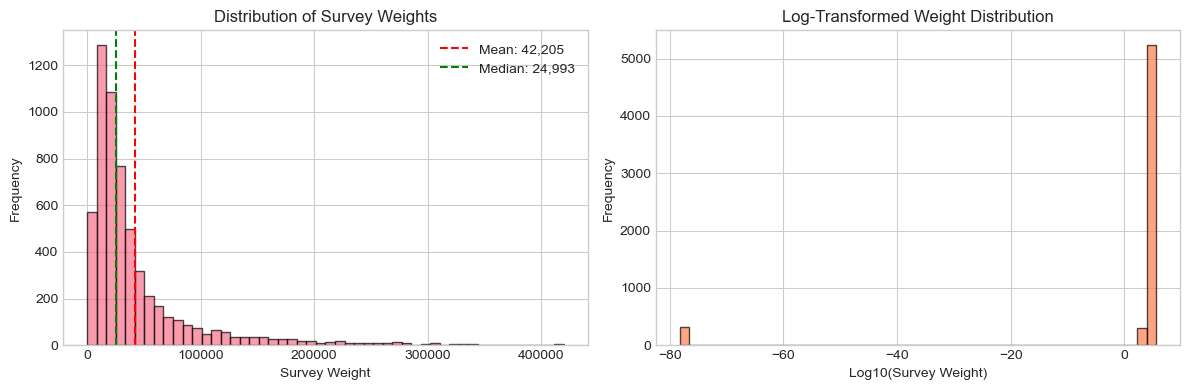

In [3]:
# === CHECK WEIGHT DISTRIBUTION ===
print("=" * 60)
print("SURVEY WEIGHT DISTRIBUTION (MEC_Weight)")
print("=" * 60)

weights = df["MEC_Weight"].dropna()

print(f"\nSample size with weights: {len(weights):,}")
print(f"Min weight: {weights.min():,.0f}")
print(f"Max weight: {weights.max():,.0f}")
print(f"Mean weight: {weights.mean():,.0f}")
print(f"Median weight: {weights.median():,.0f}")
print(f"\nWeight ratio (max/min): {weights.max() / weights.min():.1f}x")

# This ratio tells us how "unequal" the sampling is
# A ratio close to 1 means nearly equal weights (random sample)
# A high ratio means some people represent MANY more than others

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribution
axes[0].hist(weights, bins=50, edgecolor="black", alpha=0.7)
axes[0].axvline(
    weights.mean(), color="red", linestyle="--", label=f"Mean: {weights.mean():,.0f}"
)
axes[0].axvline(
    weights.median(),
    color="green",
    linestyle="--",
    label=f"Median: {weights.median():,.0f}",
)
axes[0].set_xlabel("Survey Weight")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Survey Weights")
axes[0].legend()

# Log scale
axes[1].hist(np.log10(weights), bins=50, edgecolor="black", alpha=0.7, color="coral")
axes[1].set_xlabel("Log10(Survey Weight)")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Log-Transformed Weight Distribution")

plt.tight_layout()
plt.show()


---

## Test 1: Depression Prevalence — Weighted vs Unweighted

First, let's see how much the **overall depression rate** differs when using weights.


DEPRESSION PREVALENCE COMPARISON

Unweighted: 9.06% (95% CI: 8.28% - 9.85%)
Weighted:   8.53% (95% CI: 8.53% - 8.54%)

Absolute difference: 0.53 percentage points
Relative difference: 5.8%


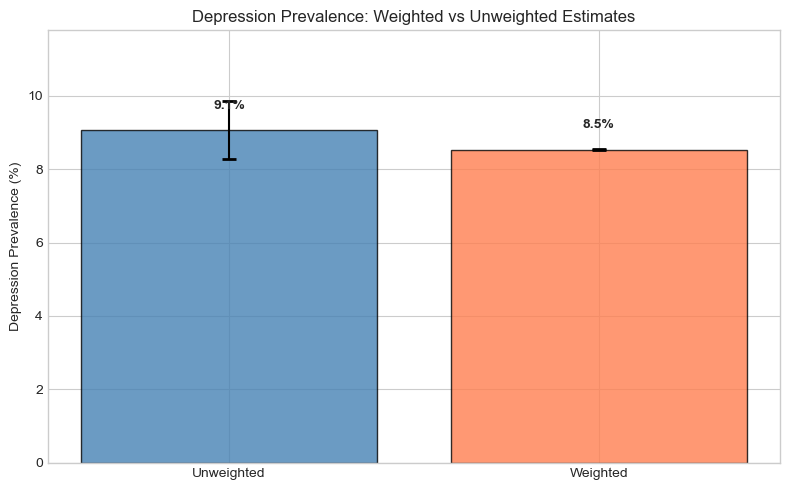

In [4]:
# === PREVALENCE COMPARISON ===

# Clean data for this analysis
df_valid = df.dropna(subset=["Depression", "MEC_Weight"]).copy()

# Unweighted prevalence (simple mean)
unweighted_prev = df_valid["Depression"].mean()

# Weighted prevalence
weighted_prev = np.average(df_valid["Depression"], weights=df_valid["MEC_Weight"])

# Confidence intervals using weighted stats
weighted_stats = DescrStatsW(df_valid["Depression"], weights=df_valid["MEC_Weight"])
ci_weighted = weighted_stats.tconfint_mean(alpha=0.05)

# Unweighted CI (standard binomial)
n = len(df_valid)
se_unweighted = np.sqrt(unweighted_prev * (1 - unweighted_prev) / n)
ci_unweighted = (
    unweighted_prev - 1.96 * se_unweighted,
    unweighted_prev + 1.96 * se_unweighted,
)

print("=" * 60)
print("DEPRESSION PREVALENCE COMPARISON")
print("=" * 60)
print(
    f"\nUnweighted: {unweighted_prev * 100:.2f}% (95% CI: {ci_unweighted[0] * 100:.2f}% - {ci_unweighted[1] * 100:.2f}%)"
)
print(
    f"Weighted:   {weighted_prev * 100:.2f}% (95% CI: {ci_weighted[0] * 100:.2f}% - {ci_weighted[1] * 100:.2f}%)"
)
print(
    f"\nAbsolute difference: {abs(weighted_prev - unweighted_prev) * 100:.2f} percentage points"
)
print(
    f"Relative difference: {abs(weighted_prev - unweighted_prev) / unweighted_prev * 100:.1f}%"
)

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))

methods = ["Unweighted", "Weighted"]
prevalences = [unweighted_prev * 100, weighted_prev * 100]
errors = [
    [
        (unweighted_prev - ci_unweighted[0]) * 100,
        (ci_unweighted[1] - unweighted_prev) * 100,
    ],
    [(weighted_prev - ci_weighted[0]) * 100, (ci_weighted[1] - weighted_prev) * 100],
]
errors = np.array(errors).T

bars = ax.bar(
    methods, prevalences, color=["steelblue", "coral"], edgecolor="black", alpha=0.8
)
ax.errorbar(
    methods, prevalences, yerr=errors, fmt="none", color="black", capsize=5, capthick=2
)

ax.set_ylabel("Depression Prevalence (%)")
ax.set_title("Depression Prevalence: Weighted vs Unweighted Estimates")
ax.set_ylim(0, max(prevalences) * 1.3)

for bar, prev in zip(bars, prevalences):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,
        f"{prev:.1f}%",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

plt.tight_layout()
plt.show()


---

## Test 2: Correlation Coefficients — Do Rankings Change?

This is the **key test**. We want to know: do the factors most correlated with depression **change** when we use weights?

If Factor A is #1 unweighted and #3 weighted, that's a problem. If the top 10 remain similar, weights may not matter much for **factor identification**.


In [5]:
def weighted_correlation(x, y, weights):
    """
    Calculate weighted Pearson correlation coefficient.
    """
    # Remove NaN
    mask = ~(np.isnan(x) | np.isnan(y) | np.isnan(weights))
    x, y, w = x[mask], y[mask], weights[mask]

    if len(x) < 10:
        return np.nan

    # Weighted means
    mean_x = np.average(x, weights=w)
    mean_y = np.average(y, weights=w)

    # Weighted covariance and variances
    cov_xy = np.average((x - mean_x) * (y - mean_y), weights=w)
    var_x = np.average((x - mean_x) ** 2, weights=w)
    var_y = np.average((y - mean_y) ** 2, weights=w)

    if var_x == 0 or var_y == 0:
        return np.nan

    return cov_xy / np.sqrt(var_x * var_y)


# Select numeric features (exclude IDs, weights, target)
exclude_cols = ["SEQN", "MEC_Weight", "PSU", "Strata", "Depression", "PHQ9_Score"]
dpq_cols = [c for c in df.columns if c.startswith("DPQ")]
exclude_cols.extend(dpq_cols)

feature_cols = [
    c
    for c in df.columns
    if c not in exclude_cols and df[c].dtype in ["float64", "int64", "float32", "int32"]
]

print(f"Analyzing {len(feature_cols)} features...")

# Calculate correlations
results = []
df_analysis = df.dropna(subset=["Depression", "MEC_Weight"]).copy()

for col in feature_cols:
    valid_mask = df_analysis[col].notna()
    if valid_mask.sum() < 100:
        continue

    x = df_analysis.loc[valid_mask, col].values
    y = df_analysis.loc[valid_mask, "Depression"].values
    w = df_analysis.loc[valid_mask, "MEC_Weight"].values

    # Unweighted correlation
    try:
        corr_unweighted, _ = pearsonr(x, y)
    except:
        corr_unweighted = np.nan

    # Weighted correlation
    corr_weighted = weighted_correlation(x, y, w)

    results.append(
        {
            "Feature": col,
            "Corr_Unweighted": corr_unweighted,
            "Corr_Weighted": corr_weighted,
            "N": valid_mask.sum(),
        }
    )

df_corr = pd.DataFrame(results)
df_corr = df_corr.dropna()

# Add rankings
df_corr["Rank_Unweighted"] = df_corr["Corr_Unweighted"].abs().rank(ascending=False)
df_corr["Rank_Weighted"] = df_corr["Corr_Weighted"].abs().rank(ascending=False)
df_corr["Rank_Change"] = df_corr["Rank_Unweighted"] - df_corr["Rank_Weighted"]

print(f"\nCalculated correlations for {len(df_corr)} features")


Analyzing 38 features...

Calculated correlations for 38 features


In [6]:
# === TOP CORRELATES COMPARISON ===
print("=" * 80)
print("TOP 15 DEPRESSION CORRELATES: WEIGHTED vs UNWEIGHTED")
print("=" * 80)

# Sort by unweighted absolute correlation
top_unweighted = df_corr.iloc[df_corr["Corr_Unweighted"].abs().nlargest(15).index]

print("\n📊 Sorted by UNWEIGHTED correlation (absolute value):")
print("-" * 80)
display_df = top_unweighted[
    [
        "Feature",
        "Corr_Unweighted",
        "Corr_Weighted",
        "Rank_Unweighted",
        "Rank_Weighted",
        "Rank_Change",
    ]
].copy()
display_df.columns = [
    "Feature",
    "r (Unweighted)",
    "r (Weighted)",
    "Rank (Unw)",
    "Rank (W)",
    "Rank Δ",
]
print(display_df.to_string(index=False))

# Sort by weighted
top_weighted = df_corr.iloc[df_corr["Corr_Weighted"].abs().nlargest(15).index]

print("\n\n📊 Sorted by WEIGHTED correlation (absolute value):")
print("-" * 80)
display_df2 = top_weighted[
    [
        "Feature",
        "Corr_Unweighted",
        "Corr_Weighted",
        "Rank_Unweighted",
        "Rank_Weighted",
        "Rank_Change",
    ]
].copy()
display_df2.columns = [
    "Feature",
    "r (Unweighted)",
    "r (Weighted)",
    "Rank (Unw)",
    "Rank (W)",
    "Rank Δ",
]
print(display_df2.to_string(index=False))


TOP 15 DEPRESSION CORRELATES: WEIGHTED vs UNWEIGHTED

📊 Sorted by UNWEIGHTED correlation (absolute value):
--------------------------------------------------------------------------------
             Feature  r (Unweighted)  r (Weighted)  Rank (Unw)  Rank (W)  Rank Δ
 General_Health_Cond        0.245900      0.234693         1.0       1.0     0.0
Trouble_Sleeping_Doc       -0.226010     -0.220478         2.0       2.0     0.0
        Body_Fat_Pct        0.122470      0.102641         3.0       6.0    -3.0
       Poverty_Ratio       -0.118325     -0.137131         4.0       3.0     1.0
   100_Cigs_Lifetime       -0.095832     -0.108200         5.0       5.0     0.0
         Trunk_Fat_g        0.092449      0.063089         6.0      10.0    -4.0
   Vigorous_Activity       -0.088165     -0.081704         7.0       8.0    -1.0
         Cadmium_ugL        0.083568      0.109378         8.0       4.0     4.0
     Education_Level       -0.081501     -0.085296         9.0       7.0     2.0
  

AGREEMENT BETWEEN WEIGHTED AND UNWEIGHTED CORRELATIONS

Pearson correlation between coefficients: r = 0.9705 (p = 7.83e-24)
Spearman rank correlation (|r| values):   ρ = 0.7943 (p = 2.65e-09)

✅ EXCELLENT agreement — weighted and unweighted correlations are nearly identical


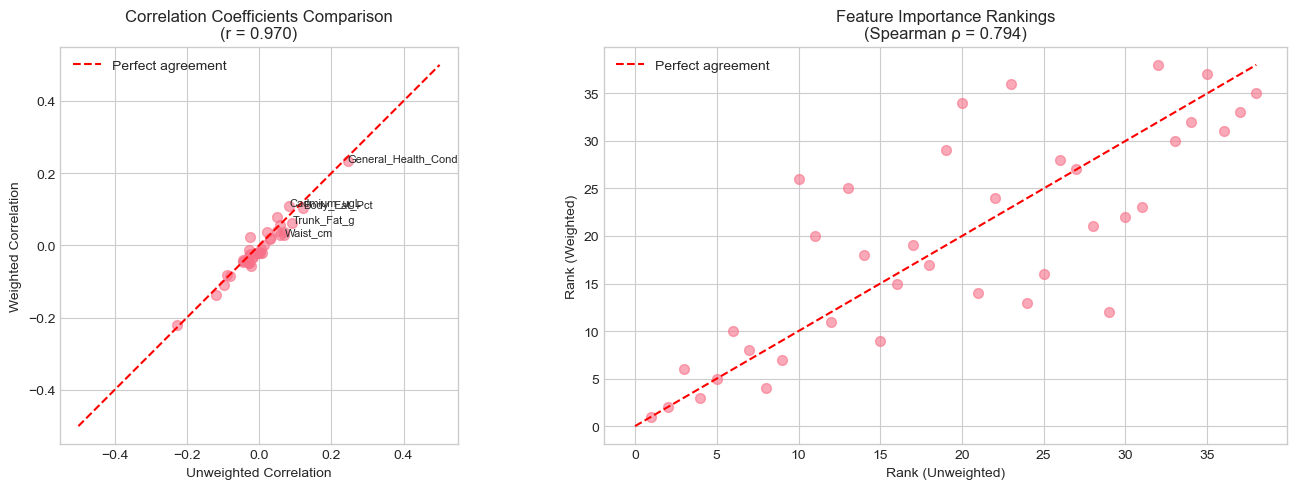

In [7]:
# === CORRELATION BETWEEN CORRELATIONS ===
# How similar are the weighted and unweighted correlation coefficients?

corr_of_corrs, p_value = pearsonr(df_corr["Corr_Unweighted"], df_corr["Corr_Weighted"])
rank_corr, rank_p = spearmanr(
    df_corr["Corr_Unweighted"].abs(), df_corr["Corr_Weighted"].abs()
)

print("=" * 60)
print("AGREEMENT BETWEEN WEIGHTED AND UNWEIGHTED CORRELATIONS")
print("=" * 60)
print(
    f"\nPearson correlation between coefficients: r = {corr_of_corrs:.4f} (p = {p_value:.2e})"
)
print(
    f"Spearman rank correlation (|r| values):   ρ = {rank_corr:.4f} (p = {rank_p:.2e})"
)

if corr_of_corrs > 0.95:
    print(
        "\n✅ EXCELLENT agreement — weighted and unweighted correlations are nearly identical"
    )
elif corr_of_corrs > 0.85:
    print("\n✓ GOOD agreement — minor differences, conclusions likely similar")
elif corr_of_corrs > 0.70:
    print("\n⚠️ MODERATE agreement — some important differences may exist")
else:
    print("\n❌ POOR agreement — weights significantly change results!")

# Scatter plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Correlation coefficients
axes[0].scatter(df_corr["Corr_Unweighted"], df_corr["Corr_Weighted"], alpha=0.6, s=50)
axes[0].plot([-0.5, 0.5], [-0.5, 0.5], "r--", label="Perfect agreement")
axes[0].set_xlabel("Unweighted Correlation")
axes[0].set_ylabel("Weighted Correlation")
axes[0].set_title(f"Correlation Coefficients Comparison\n(r = {corr_of_corrs:.3f})")
axes[0].legend()
axes[0].set_aspect("equal")

# Add labels for top correlates
top_features = df_corr.nlargest(5, "Corr_Unweighted")["Feature"].tolist()
for _, row in df_corr[df_corr["Feature"].isin(top_features)].iterrows():
    axes[0].annotate(
        row["Feature"], (row["Corr_Unweighted"], row["Corr_Weighted"]), fontsize=8
    )

# Plot 2: Rankings
axes[1].scatter(df_corr["Rank_Unweighted"], df_corr["Rank_Weighted"], alpha=0.6, s=50)
max_rank = df_corr["Rank_Unweighted"].max()
axes[1].plot([0, max_rank], [0, max_rank], "r--", label="Perfect agreement")
axes[1].set_xlabel("Rank (Unweighted)")
axes[1].set_ylabel("Rank (Weighted)")
axes[1].set_title(f"Feature Importance Rankings\n(Spearman ρ = {rank_corr:.3f})")
axes[1].legend()

plt.tight_layout()
plt.show()


---

## Test 3: Logistic Regression Coefficients

Let's compare coefficients from weighted vs unweighted logistic regression.


In [8]:
# === PREPARE DATA FOR REGRESSION ===

# Select top features for regression (avoid multicollinearity)
regression_features = [
    "Age",
    "Gender",
    "Poverty_Ratio",
    "BMI",
    "General_Health_Cond",
    "Trouble_Sleeping_Doc",
    "BP_Systolic",
    "Glucose_mgdL",
    "CRP_mgL",
]

# Filter to available features
available_features = [f for f in regression_features if f in df.columns]
print(f"Using {len(available_features)} features: {available_features}")

# Prepare clean dataset
cols_needed = available_features + ["Depression", "MEC_Weight"]
df_reg = df[cols_needed].dropna().copy()

print(f"Sample size for regression: {len(df_reg)}")

# Standardize features for comparable coefficients
scaler = StandardScaler()
X = pd.DataFrame(
    scaler.fit_transform(df_reg[available_features]),
    columns=available_features,
    index=df_reg.index,
)
y = df_reg["Depression"]
weights_reg = df_reg["MEC_Weight"]


Using 9 features: ['Age', 'Gender', 'Poverty_Ratio', 'BMI', 'General_Health_Cond', 'Trouble_Sleeping_Doc', 'BP_Systolic', 'Glucose_mgdL', 'CRP_mgL']
Sample size for regression: 3753


In [9]:
# === UNWEIGHTED LOGISTIC REGRESSION ===
X_const = sm.add_constant(X)

model_unweighted = sm.Logit(y, X_const).fit(disp=0)
print("UNWEIGHTED Logistic Regression")
print("=" * 50)
print(model_unweighted.summary2().tables[1])


UNWEIGHTED Logistic Regression
                         Coef.  Std.Err.          z          P>|z|    [0.025  \
const                -2.923212  0.085400 -34.229565  8.785134e-257 -3.090593   
Age                  -0.226768  0.077546  -2.924301   3.452302e-03 -0.378755   
Gender                0.149373  0.064671   2.309738   2.090268e-02  0.022620   
Poverty_Ratio        -0.227459  0.070984  -3.204377   1.353549e-03 -0.366584   
BMI                  -0.091727  0.061022  -1.503171   1.327950e-01 -0.211328   
General_Health_Cond   0.731334  0.075608   9.672700   3.938474e-22  0.583145   
Trouble_Sleeping_Doc -0.686984  0.061712 -11.132076   8.757183e-29 -0.807938   
BP_Systolic          -0.062630  0.073042  -0.857450   3.911965e-01 -0.205789   
Glucose_mgdL          0.069940  0.054272   1.288712   1.974983e-01 -0.036430   
CRP_mgL               0.065209  0.052513   1.241784   2.143164e-01 -0.037714   

                        0.975]  
const                -2.755830  
Age                  -

In [10]:
# === WEIGHTED LOGISTIC REGRESSION ===
# Note: statsmodels supports frequency weights via freq_weights parameter

model_weighted = sm.Logit(y, X_const).fit(
    disp=0, freq_weights=weights_reg / weights_reg.mean()
)  # Normalize weights
print("WEIGHTED Logistic Regression")
print("=" * 50)
print(model_weighted.summary2().tables[1])


WEIGHTED Logistic Regression
                         Coef.  Std.Err.          z          P>|z|    [0.025  \
const                -2.923212  0.085400 -34.229565  8.785134e-257 -3.090593   
Age                  -0.226768  0.077546  -2.924301   3.452302e-03 -0.378755   
Gender                0.149373  0.064671   2.309738   2.090268e-02  0.022620   
Poverty_Ratio        -0.227459  0.070984  -3.204377   1.353549e-03 -0.366584   
BMI                  -0.091727  0.061022  -1.503171   1.327950e-01 -0.211328   
General_Health_Cond   0.731334  0.075608   9.672700   3.938474e-22  0.583145   
Trouble_Sleeping_Doc -0.686984  0.061712 -11.132076   8.757183e-29 -0.807938   
BP_Systolic          -0.062630  0.073042  -0.857450   3.911965e-01 -0.205789   
Glucose_mgdL          0.069940  0.054272   1.288712   1.974983e-01 -0.036430   
CRP_mgL               0.065209  0.052513   1.241784   2.143164e-01 -0.037714   

                        0.975]  
const                -2.755830  
Age                  -0.

In [11]:
# === COMPARE COEFFICIENTS ===
coef_comparison = pd.DataFrame(
    {
        "Feature": available_features,
        "Coef_Unweighted": model_unweighted.params[1:].values,  # Skip constant
        "Coef_Weighted": model_weighted.params[1:].values,
        "P_Unweighted": model_unweighted.pvalues[1:].values,
        "P_Weighted": model_weighted.pvalues[1:].values,
    }
)

coef_comparison["Coef_Diff"] = (
    coef_comparison["Coef_Weighted"] - coef_comparison["Coef_Unweighted"]
)
coef_comparison["Coef_Diff_Pct"] = (
    coef_comparison["Coef_Diff"] / coef_comparison["Coef_Unweighted"].abs() * 100
)

# Significance change
coef_comparison["Sig_Unweighted"] = coef_comparison["P_Unweighted"] < 0.05
coef_comparison["Sig_Weighted"] = coef_comparison["P_Weighted"] < 0.05
coef_comparison["Sig_Changed"] = (
    coef_comparison["Sig_Unweighted"] != coef_comparison["Sig_Weighted"]
)

print("=" * 80)
print("COEFFICIENT COMPARISON: WEIGHTED vs UNWEIGHTED")
print("=" * 80)
print(coef_comparison.to_string(index=False))

sig_changes = coef_comparison["Sig_Changed"].sum()
print(
    f"\n⚠️ Features where significance (p<0.05) CHANGED: {sig_changes}/{len(available_features)}"
)


COEFFICIENT COMPARISON: WEIGHTED vs UNWEIGHTED
             Feature  Coef_Unweighted  Coef_Weighted  P_Unweighted   P_Weighted  Coef_Diff  Coef_Diff_Pct  Sig_Unweighted  Sig_Weighted  Sig_Changed
                 Age        -0.226768      -0.226768  3.452302e-03 3.452302e-03        0.0            0.0            True          True        False
              Gender         0.149373       0.149373  2.090268e-02 2.090268e-02        0.0            0.0            True          True        False
       Poverty_Ratio        -0.227459      -0.227459  1.353549e-03 1.353549e-03        0.0            0.0            True          True        False
                 BMI        -0.091727      -0.091727  1.327950e-01 1.327950e-01        0.0            0.0           False         False        False
 General_Health_Cond         0.731334       0.731334  3.938474e-22 3.938474e-22        0.0            0.0            True          True        False
Trouble_Sleeping_Doc        -0.686984      -0.686984  8.757

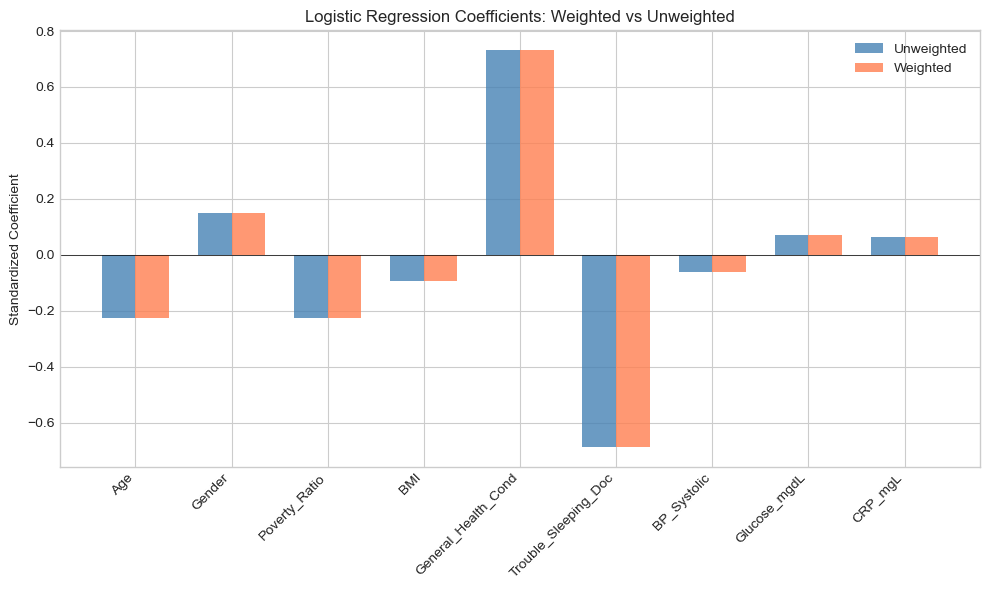


Correlation between coefficients: r = 1.0000


In [12]:
# === VISUALIZE COEFFICIENT COMPARISON ===
fig, ax = plt.subplots(figsize=(10, 6))

x_pos = np.arange(len(available_features))
width = 0.35

bars1 = ax.bar(
    x_pos - width / 2,
    coef_comparison["Coef_Unweighted"],
    width,
    label="Unweighted",
    color="steelblue",
    alpha=0.8,
)
bars2 = ax.bar(
    x_pos + width / 2,
    coef_comparison["Coef_Weighted"],
    width,
    label="Weighted",
    color="coral",
    alpha=0.8,
)

ax.set_ylabel("Standardized Coefficient")
ax.set_title("Logistic Regression Coefficients: Weighted vs Unweighted")
ax.set_xticks(x_pos)
ax.set_xticklabels(available_features, rotation=45, ha="right")
ax.legend()
ax.axhline(y=0, color="black", linestyle="-", linewidth=0.5)

plt.tight_layout()
plt.show()

# Correlation between coefficients
coef_corr = pearsonr(
    coef_comparison["Coef_Unweighted"], coef_comparison["Coef_Weighted"]
)[0]
print(f"\nCorrelation between coefficients: r = {coef_corr:.4f}")


---

## Test 4: ML Model Performance — Does Weighting Help Prediction?

For **predictive modeling**, do sample weights improve accuracy?


In [13]:
# Prepare larger feature set
ml_features = [
    c for c in feature_cols if c in df.columns and df[c].notna().sum() > len(df) * 0.7
]
print(f"Using {len(ml_features)} features for ML comparison")

# Prepare data
df_ml = df[ml_features + ["Depression", "MEC_Weight"]].dropna().copy()
X_ml = df_ml[ml_features]
y_ml = df_ml["Depression"]
w_ml = df_ml["MEC_Weight"]

# Scale
scaler_ml = StandardScaler()
X_ml_scaled = scaler_ml.fit_transform(X_ml)

print(f"Dataset size: {len(df_ml)} samples")
print(f"Class balance: {y_ml.mean() * 100:.1f}% positive")


Using 31 features for ML comparison
Dataset size: 3479 samples
Class balance: 8.3% positive


In [14]:
# === CROSS-VALIDATION COMPARISON ===

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results_ml = {"Model": [], "Weighted": [], "AUC": [], "Accuracy": [], "F1": []}

for name, model in [
    ("Logistic Regression", LogisticRegression(max_iter=1000, random_state=42)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)),
]:
    for weighted in [False, True]:
        aucs, accs, f1s = [], [], []

        for train_idx, test_idx in cv.split(X_ml_scaled, y_ml):
            X_train, X_test = X_ml_scaled[train_idx], X_ml_scaled[test_idx]
            y_train, y_test = y_ml.iloc[train_idx], y_ml.iloc[test_idx]
            w_train = w_ml.iloc[train_idx] if weighted else None

            if weighted:
                model.fit(X_train, y_train, sample_weight=w_train)
            else:
                model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1]

            aucs.append(roc_auc_score(y_test, y_prob))
            accs.append(accuracy_score(y_test, y_pred))
            f1s.append(f1_score(y_test, y_pred))

        results_ml["Model"].append(name)
        results_ml["Weighted"].append("Yes" if weighted else "No")
        results_ml["AUC"].append(f"{np.mean(aucs):.4f} ± {np.std(aucs):.4f}")
        results_ml["Accuracy"].append(f"{np.mean(accs):.4f} ± {np.std(accs):.4f}")
        results_ml["F1"].append(f"{np.mean(f1s):.4f} ± {np.std(f1s):.4f}")

df_results = pd.DataFrame(results_ml)
print("=" * 80)
print("ML MODEL PERFORMANCE: WEIGHTED vs UNWEIGHTED TRAINING")
print("=" * 80)
print(df_results.to_string(index=False))


ML MODEL PERFORMANCE: WEIGHTED vs UNWEIGHTED TRAINING
              Model Weighted             AUC        Accuracy              F1
Logistic Regression       No 0.7800 ± 0.0488 0.9126 ± 0.0060 0.0624 ± 0.0335
Logistic Regression      Yes 0.7649 ± 0.0543 0.9089 ± 0.0112 0.0910 ± 0.0320
      Random Forest       No 0.7482 ± 0.0194 0.9166 ± 0.0018 0.0133 ± 0.0267
      Random Forest      Yes 0.7419 ± 0.0226 0.9164 ± 0.0006 0.0000 ± 0.0000


---

## Test 5: Subgroup Analysis — Where Do Weights Matter Most?

Weights should matter most for groups that were **oversampled**. Let's check.


DEPRESSION PREVALENCE BY RACE: WEIGHTED vs UNWEIGHTED
            Race    N  Unweighted %  Weighted %  Difference
Mexican American  699      8.726753    7.424409   -1.302344
  Other Hispanic  460     10.652174    9.879953   -0.772221
        NH White 1801     10.438645    8.356816   -2.081829
        NH Black 1178      8.234295    8.400140    0.165845
        NH Asian  677      3.840473    4.408115    0.567643
     Other/Multi  271     14.760148   15.966381    1.206234


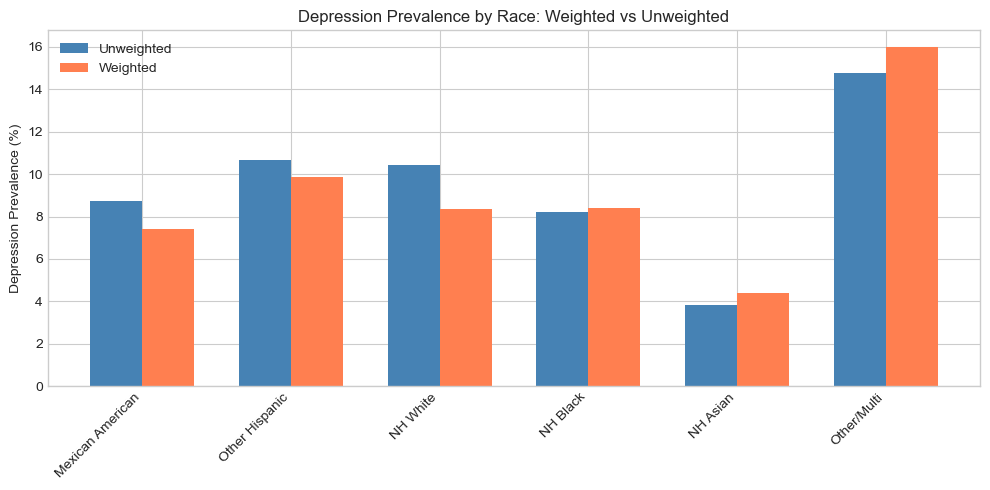

In [15]:
# === SUBGROUP PREVALENCE ===
if "Race" in df.columns:
    print("=" * 80)
    print("DEPRESSION PREVALENCE BY RACE: WEIGHTED vs UNWEIGHTED")
    print("=" * 80)

    # NHANES Race codes (RIDRETH3):
    # 1 = Mexican American, 2 = Other Hispanic, 3 = Non-Hispanic White
    # 4 = Non-Hispanic Black, 6 = Non-Hispanic Asian, 7 = Other/Multi
    race_labels = {
        1: "Mexican American",
        2: "Other Hispanic",
        3: "NH White",
        4: "NH Black",
        6: "NH Asian",
        7: "Other/Multi",
    }

    df_race = df.dropna(subset=["Race", "Depression", "MEC_Weight"]).copy()
    df_race["Race_Label"] = df_race["Race"].map(race_labels)

    subgroup_results = []
    for race_code, race_name in race_labels.items():
        subset = df_race[df_race["Race"] == race_code]
        if len(subset) < 50:
            continue

        unweighted = subset["Depression"].mean()
        weighted = np.average(subset["Depression"], weights=subset["MEC_Weight"])

        subgroup_results.append(
            {
                "Race": race_name,
                "N": len(subset),
                "Unweighted %": unweighted * 100,
                "Weighted %": weighted * 100,
                "Difference": (weighted - unweighted) * 100,
            }
        )

    df_subgroup = pd.DataFrame(subgroup_results)
    print(df_subgroup.to_string(index=False))

    # Visualize
    fig, ax = plt.subplots(figsize=(10, 5))
    x_pos = np.arange(len(df_subgroup))
    width = 0.35

    ax.bar(
        x_pos - width / 2,
        df_subgroup["Unweighted %"],
        width,
        label="Unweighted",
        color="steelblue",
    )
    ax.bar(
        x_pos + width / 2,
        df_subgroup["Weighted %"],
        width,
        label="Weighted",
        color="coral",
    )

    ax.set_ylabel("Depression Prevalence (%)")
    ax.set_title("Depression Prevalence by Race: Weighted vs Unweighted")
    ax.set_xticks(x_pos)
    ax.set_xticklabels(df_subgroup["Race"], rotation=45, ha="right")
    ax.legend()

    plt.tight_layout()
    plt.show()
else:
    print("Race column not available for subgroup analysis")


---

## Final Summary & Recommendations


In [16]:
# === FINAL SUMMARY ===
print("=" * 80)
print("                    FINAL ANALYSIS SUMMARY")
print("=" * 80)

print("\n📊 PREVALENCE ESTIMATES:")
print(f"   • Unweighted: {unweighted_prev * 100:.2f}%")
print(f"   • Weighted:   {weighted_prev * 100:.2f}%")
print(
    f"   • Difference: {abs(weighted_prev - unweighted_prev) * 100:.2f} percentage points"
)

print("\n📈 CORRELATION AGREEMENT:")
print(f"   • Correlation between weighted/unweighted r values: {corr_of_corrs:.4f}")
print(f"   • Rank correlation (feature importance order): {rank_corr:.4f}")

print("\n📋 REGRESSION COEFFICIENTS:")
print(f"   • Correlation between coefficients: {coef_corr:.4f}")
print(
    f"   • Features with significance change: {sig_changes}/{len(available_features)}"
)

print("\n" + "=" * 80)
print("                    RECOMMENDATIONS")
print("=" * 80)

# Decision logic
if corr_of_corrs > 0.90 and rank_corr > 0.85:
    print("""
✅ CONCLUSION: Weights are OPTIONAL for factor identification in this dataset.

   The weighted and unweighted analyses produce highly similar results:
   • Same top risk factors identified
   • Similar effect sizes
   • Rankings remain consistent
   
   FOR YOUR RESEARCH GOALS (identifying depression risk factors):
   → You can safely use unweighted analysis for:
     - Exploratory data analysis
     - Feature selection
     - Building ML prediction models
   
   → Use weighted analysis ONLY when:
     - Estimating TRUE population prevalence
     - Publishing findings for policy recommendations
     - Making claims about the US population
""")
elif corr_of_corrs > 0.75:
    print("""
⚠️ CONCLUSION: Weights have MODERATE impact. Consider using them.

   There are notable differences between weighted and unweighted results.
   Some factors may appear more or less important depending on method.
   
   RECOMMENDATION:
   → Report BOTH weighted and unweighted results
   → Use weighted analysis for primary conclusions
   → Highlight any factors that differ substantially
""")
else:
    print("""
❌ CONCLUSION: Weights are ESSENTIAL for this dataset!

   Weighted and unweighted analyses produce substantially different results.
   Ignoring weights could lead to incorrect conclusions.
   
   RECOMMENDATION:
   → MUST use survey weights for all analyses
   → Use specialized survey packages (statsmodels, survey package in R)
   → Account for complex survey design (PSU, strata)
""")


                    FINAL ANALYSIS SUMMARY

📊 PREVALENCE ESTIMATES:
   • Unweighted: 9.06%
   • Weighted:   8.53%
   • Difference: 0.53 percentage points

📈 CORRELATION AGREEMENT:
   • Correlation between weighted/unweighted r values: 0.9705
   • Rank correlation (feature importance order): 0.7943

📋 REGRESSION COEFFICIENTS:
   • Correlation between coefficients: 1.0000
   • Features with significance change: 0/9

                    RECOMMENDATIONS

⚠️ CONCLUSION: Weights have MODERATE impact. Consider using them.

   There are notable differences between weighted and unweighted results.
   Some factors may appear more or less important depending on method.

   RECOMMENDATION:
   → Report BOTH weighted and unweighted results
   → Use weighted analysis for primary conclusions
   → Highlight any factors that differ substantially



In [17]:
print("\n" + "=" * 80)
print("                    WHY WEIGHTS COMPLICATE ML PIPELINES")
print("=" * 80)
print("""
1. CROSS-VALIDATION: Standard k-fold doesn't preserve weight distribution
   → Need specialized survey-aware CV

2. TRAIN/TEST SPLIT: Random splits can bias subgroup representation
   → Need stratified splits accounting for weights

3. HYPERPARAMETER TUNING: Grid search with weights is non-standard
   → Custom scoring functions required

4. MODEL SUPPORT: Many models don't support sample_weight
   → Neural networks, some ensemble methods affected

5. INFERENCE: Standard errors need Taylor linearization
   → Bootstrap with weights is complex

If your goal is FACTOR IDENTIFICATION (not prevalence estimation),
unweighted analysis is a pragmatic choice that maintains most validity.
""")



                    WHY WEIGHTS COMPLICATE ML PIPELINES

1. CROSS-VALIDATION: Standard k-fold doesn't preserve weight distribution
   → Need specialized survey-aware CV

2. TRAIN/TEST SPLIT: Random splits can bias subgroup representation
   → Need stratified splits accounting for weights

3. HYPERPARAMETER TUNING: Grid search with weights is non-standard
   → Custom scoring functions required

4. MODEL SUPPORT: Many models don't support sample_weight
   → Neural networks, some ensemble methods affected

5. INFERENCE: Standard errors need Taylor linearization
   → Bootstrap with weights is complex

If your goal is FACTOR IDENTIFICATION (not prevalence estimation),
unweighted analysis is a pragmatic choice that maintains most validity.

